# Load modules

In [1]:
# only use if editing pyMMG module. Otherwise comment lines.
# WARNING: autoreload overwrites custom config in pyMMG
#
#%load_ext autoreload
#%autoreload 2

In [2]:
import pyMMG as pyMMG
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats
import plotly.graph_objects as go
from ipywidgets import interact
import pprint

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Preprocess data

Load dataset into a dataframe, apply band-pass filtering to MMG signal and low-pass filtering to Force signal, and apply wavelet thresholding to MMG signal

In [3]:
# Sampling frequency
fs = 400.96

# Root of dataset folder
root = "dataset/"

# MMG high-pass cut-off frequency
mmg_hp_fc = 25.0 # fs/1000 < f < fs/2 or None to disable

# MMG low-pass cut-off frequency
mmg_lp_fc = None # fs/1000 < f < fs/2 or None to disable

# MMG low-pass cut-off frequency
force_lp_fc = 3.0 # fs/1000 < f < fs/2 or None to disable

# Wavelet Thresholding config
wt_enable = True # enable or disable
wt_wavelet = 'db10' # mother wavelet

# Load dataset, apply filters and apply wavelet thresholding
data = pyMMG.preprocessing.CSVToDataFrame(root, fs, fc_mmg=(mmg_hp_fc, mmg_lp_fc), fc_force=force_lp_fc, wavelet_thresholding=wt_enable, wavelet=wt_wavelet)

Reading file:  rodrigo_initialMVC_rmvc1_try_1.csv
Subject:  rodrigo
Test type:  initialMVC
Test ID:  rmvc1
Test metadata ['try', '1'] 

Reading file:  manuel_endurancetime_mlet3_target_50.csv
Subject:  manuel
Test type:  endurancetime
Test ID:  mlet3
Test metadata ['target', '50'] 

Reading file:  manuel_initialMVC_mlmvc3_try_3.csv
Subject:  manuel
Test type:  initialMVC
Test ID:  mlmvc3
Test metadata ['try', '3'] 

Reading file:  manuel_force_mlf7_target_30.csv
Subject:  manuel
Test type:  force
Test ID:  mlf7
Test metadata ['target', '30'] 

Reading file:  matiasg_endurancetime_mget1_target_70.csv
Subject:  matiasg
Test type:  endurancetime
Test ID:  mget1
Test metadata ['target', '70'] 

Reading file:  manuel_endurancetime_mlet1_target_70.csv
Subject:  manuel
Test type:  endurancetime
Test ID:  mlet1
Test metadata ['target', '70'] 

Reading file:  matiasm_initialMVC_mmmvc2_try_2.csv
Subject:  matiasm
Test type:  initialMVC
Test ID:  mmmvc2
Test metadata ['try', '2'] 

Reading file: 

Crop Force tests using test target force. It keeps N points previous to the last point when the measured force is above 100-T% of the target force.

In [4]:
N = 400*5 # 5s @ 400 Hz
T = 5.0
data = pyMMG.preprocessing.CropForceTestToTargetForce(data, tolerance=T/100.0, n_points=N)

MVC: [49.46722132] Target: [44.52049919] Bounds: ( [42.29447423] ; [46.74652415] )
MVC: [49.46722132] Target: [39.57377706] Bounds: ( [37.5950882] ; [41.55246591] )
MVC: [49.46722132] Target: [34.62705492] Bounds: ( [32.89570218] ; [36.35840767] )
MVC: [49.46722132] Target: [29.68033279] Bounds: ( [28.19631615] ; [31.16434943] )
MVC: [49.46722132] Target: [24.73361066] Bounds: ( [23.49693013] ; [25.97029119] )
MVC: [49.46722132] Target: [19.78688853] Bounds: ( [18.7975441] ; [20.77623295] )
MVC: [49.46722132] Target: [14.8401664] Bounds: ( [14.09815808] ; [15.58217472] )
MVC: [49.46722132] Target: [9.89344426] Bounds: ( [9.39877205] ; [10.38811648] )
MVC: [49.46722132] Target: [4.94672213] Bounds: ( [4.69938603] ; [5.19405824] )
MVC: [75.41201557] Target: [67.87081402] Bounds: ( [64.47727332] ; [71.26435472] )
MVC: [75.41201557] Target: [60.32961246] Bounds: ( [57.31313184] ; [63.34609308] )
MVC: [75.41201557] Target: [52.7884109] Bounds: ( [50.14899036] ; [55.42783145] )
MVC: [75.4120

Crop Endurance tests using target force. It keeps all points beetwen first and last points when measured force is above 100-T% of the target force.

In [5]:
T = 5.0
data = pyMMG.preprocessing.CropEnduranceTimeTest(data, tolerance=T/100.0)

Save preprocessed data in pandas dataframe structure as a csv file

In [6]:
data.to_csv("data.csv", sep=";", decimal=".")

# Interactive dataset visualization

Load prepocessed data from csv file

In [7]:
fs = 400.96
data = pd.read_csv("data.csv", sep=";", decimal=".", index_col=0)
data

,Subject,Test type,Test ID,Test metadata,Time,Force,MMG
0,julian,endurancetime,jet1,"['target', '70']",4.200075,31.528251,223.223008
1,julian,endurancetime,jet1,"['target', '70']",4.202569,31.577550,77.977311
2,julian,endurancetime,jet1,"['target', '70']",4.205063,31.626096,-3.618801
3,julian,endurancetime,jet1,"['target', '70']",4.207557,31.673898,-5.462955
4,julian,endurancetime,jet1,"['target', '70']",4.210051,31.720966,-43.140981
...,...,...,...,...,...,...,...
778844,rodrigo,initialMVC,rmvc3,"['try', '3']",15.001495,2.814704,-13.653616
778845,rodrigo,initialMVC,rmvc3,"['try', '3']",15.003989,2.814702,-0.665871
778846,rodrigo,initialMVC,rmvc3,"['try', '3']",15.006484,2.814700,10.368261
778847,rodrigo,initialMVC,rmvc3,"['try', '3']",15.008978,2.814698,15.469403


Explore dataset interactivily with time-series plots, periodograms and superlet scalograms (spectrogram). Edit code for changing periodogram and superlet parameters.

In [8]:
from IPython.display import display
import plotly.express as px
import ipywidgets as widgets

output = widgets.Output()
current_data = {}

def on_spectrogram_button_clicked(b):
    with output:
        %matplotlib inline
        # change parameters here for superlet scalograms
        pyMMG.visualization.Spectrogram(current_data["y"], fs, plot_3d=False, scale_type='log')
        
spectrogram_button = widgets.Button(description="Spectrogram")
spectrogram_button.on_click(on_spectrogram_button_clicked)

fig = go.FigureWidget()
fig.add_scatter()

@interact(test_id=data["Test ID"].drop_duplicates().sort_values(), channel=["Force","MMG"], domain=["Time","Frequency","Frequency Welch"], high_pass=(0.0,fs/2,fs/100), low_pass=(0.0,fs/2,fs/100), x_scale=["Linear", "Log"], y_scale=["Linear", "Log"], N=np.arange(int(fs),int(fs)*10,int(fs/2)))
def update(test_id=data["Test ID"].iloc[0], channel="MMG", domain="Time", high_pass=0.0, low_pass=0.0, x_scale="Linear", y_scale="Linear", N=2048):
    with fig.batch_update():
        x = data["Time"][data["Test ID"] == test_id].values
        y = data[channel][data["Test ID"] == test_id].values

        if (low_pass > 1.0 and low_pass < fs/2*0.99):
            lp_filter = signal.iirfilter(8, low_pass, btype='lowpass', output='sos', fs=fs)
            y = signal.sosfiltfilt(lp_filter, y)

        if (high_pass > 1.0 and high_pass < fs/2*0.99):
            hp_filter = signal.iirfilter(8, high_pass, btype='highpass', output='sos', fs=fs)
            y = signal.sosfiltfilt(hp_filter, y)

        current_data["x"] = x
        current_data["y"] = y

        print("RMS:",np.std(y))

        if domain == "Time":
            fig.data[0].x = x
            fig.data[0].y = y
        elif domain == "Frequency Welch":
            # change parameters here for periodogram
            f,pxx = signal.welch(y, fs=fs, nperseg=N, window='hamming', scaling='spectrum')
            fig.data[0].x = f
            fig.data[0].y = pxx
        elif domain == "Frequency":
            # change parameters here for periodogram
            f,pxx = signal.periodogram(y, fs=fs, window='hamming', scaling='spectrum')
            fig.data[0].x = f
            fig.data[0].y = pxx
        else:
            fig.data[0].x = data["Index"][data["Test ID"] == test_id].values
            fig.data[0].y = y

        if x_scale == "Log":
            fig.update_xaxes(type="log")
        else:
            fig.update_xaxes(type="linear")

        if y_scale == "Log":
            fig.update_yaxes(type="log")
        else:
            fig.update_yaxes(type="linear")

display(spectrogram_button, output)
display(fig, output)

interactive(children=(Dropdown(description='test_id', options=('jet1', 'jet2', 'jet3', 'jet4', 'jf1', 'jf2', '…

Button(description='Spectrogram', style=ButtonStyle())

Output()

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': 'c1fafaf4-9c36-491d-98b0-4b37960407b7',
 …

Output()

# Calculate features

## Configuration

In this section you must set wavelet packet parameters and superlet parameters for signal feature extraction. You also have to set window lenght and overlap for moving window features and low pass filter cut-off frequency for instantaneous features. Finally, here you set which features from the MMG you want to calculate. This features must have an associate function in feature_calculator/distribution_features.py, feature_calculator/instantaenous_features.py or feature_calculator/moving_window_features.py files in pyMMG module folder. For available features look at these files.

In [9]:
# Print current config
print("Old pyMMG configuration\n")
pprint.pprint(pyMMG.GetCurrentConfig())
newConfig = pyMMG.GetCurrentConfig()

# Wavelet Packet config
newConfig["feature_calculator"]["FrequencyBandDecompose enabled"] = True
newConfig["feature_calculator"]["FrequencyBandDecompose initial_level"] = 3
newConfig["feature_calculator"]["FrequencyBandDecompose max_level"] = 3
newConfig["feature_calculator"]["FrequencyBandDecompose wavelet"] = 'db10'

# Superlet config
newConfig["feature_calculator"]["Superlet minimum N cycles"] = 3
newConfig["feature_calculator"]["Superlet max order"] = 15
newConfig["feature_calculator"]["Superlet min order"] = 5

# Moving window features config
newConfig["feature_calculator"]["Moving Window Features config"]["Overlap [0;1]"] = 0.5
newConfig["feature_calculator"]["Moving Window Features config"]["Window length [s]"] = 1.0
newConfig["feature_calculator"]["Moving Window Features"] = [
    pyMMG.feature_calculator.mw_features.ZeroCrossing,
    pyMMG.feature_calculator.mw_features.NumberOfTurns,
    pyMMG.feature_calculator.mw_features.MMGScore,
]

# Distribution features config
newConfig["feature_calculator"]["Distribution Features config"]["Low Pass Filter Cut-Off Frequency (normalized)"] = 0.5/(fs/2.0)
newConfig["feature_calculator"]["Distribution Features"] = [
    pyMMG.feature_calculator.d_features.Mean,
    pyMMG.feature_calculator.d_features.Variance,
    pyMMG.feature_calculator.d_features.Entropy,
    pyMMG.feature_calculator.d_features.InterquantileRange50,
    pyMMG.feature_calculator.d_features.Quantile25,
    pyMMG.feature_calculator.d_features.Quantile75
]

# Instantaneous features config
newConfig["feature_calculator"]["Instantaneous Features config"]["Low Pass Filter Cut-Off Frequency (normalized)"] = 0.5/(fs/2.0)
newConfig["feature_calculator"]["Instantaneous Features"] = [
    pyMMG.feature_calculator.i_features.MeanOfAmplitude,
    pyMMG.feature_calculator.i_features.Variance,
    pyMMG.feature_calculator.i_features.InstantaneousAmplitude
]

# Print new config
pyMMG.SetConfig(newConfig)
print("\n\nNew pyMMG configuration\n")
pprint.pprint(pyMMG.GetCurrentConfig())

Old pyMMG configuration

{'feature_calculator': {'Distribution Features': [<function Mean at 0x7fb8db732af0>,
                                                  <function Median at 0x7fb8db7328b0>,
                                                  <function Variance at 0x7fb8db732b80>,
                                                  <function Skewness at 0x7fb8db732c10>,
                                                  <function ExcessKurtosis at 0x7fb8db732ca0>,
                                                  <function ExcessKurtosis at 0x7fb8db732ca0>,
                                                  <function Entropy at 0x7fb8db732d30>,
                                                  <function Integral at 0x7fb8db732dc0>,
                                                  <function InterquantileRange50 at 0x7fb8db732940>,
                                                  <function Quantile25 at 0x7fb8db7329d0>,
                                                  <function Quanti

## Calculate features

Calculates features in force tests to search for highly correlated features with force production.

In [10]:
# Calculate features only in force tests
test_type = "force"
force_features = pyMMG.feature_calculator.CalculateFeatures(data.loc[data["Test type"] == test_type], fs)

# Add target force as a column in features dataframe
for grp in force_features.groupby(by="Test ID"):
    target = float(eval(grp[1]["Test metadata"].iloc[0])[1])
    force_features.loc[force_features["Test ID"] == grp[0],"Target"] = target

# Save calculated features in csv for post-processing
force_features.to_csv("force_features.csv", sep=";", decimal=".")
force_features

,Subject,Test type,Test ID,Test metadata,Time,Force,MMG,Banda aaa,Banda aad,Banda ada,...,MMG Frequency Variance (Avg),MMG Frequency Entropy,MMG Frequency Entropy (Avg),MMG Frequency InterquantileRange50,MMG Frequency InterquantileRange50 (Avg),MMG Frequency Quantile25,MMG Frequency Quantile25 (Avg),MMG Frequency Quantile75,MMG Frequency Quantile75 (Avg),Target
170445,julian,force,jf1,"['target', '90']",9.299138,40.832464,63.884386,54.667333,-15.271875,15.409826,...,475.016760,0.863617,0.807712,37.646526,29.190042,46.882173,40.987442,84.528699,70.177484,90.0
170446,julian,force,jf1,"['target', '90']",9.301633,40.847548,35.265395,34.964123,-52.565010,37.797029,...,475.015016,0.865963,0.807711,37.646526,29.189942,47.886080,40.987365,85.532606,70.177306,90.0
170447,julian,force,jf1,"['target', '90']",9.304127,40.862696,-30.129254,18.341820,-76.119470,-3.394740,...,475.009706,0.861006,0.807709,37.144573,29.189647,47.886080,40.987100,85.030653,70.176747,90.0
170448,julian,force,jf1,"['target', '90']",9.306622,40.877903,-91.217499,4.846083,-74.192455,-50.782683,...,475.000831,0.855955,0.807706,36.642619,29.189159,47.886080,40.986647,84.528699,70.175806,90.0
170449,julian,force,jf1,"['target', '90']",9.309116,40.893162,-89.412540,-5.577128,-44.971683,-15.755104,...,474.988395,0.855756,0.807701,36.642619,29.188477,48.388034,40.986007,85.030653,70.174484,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760889,rodrigo,force,rf9,"['target', '10']",15.103504,4.599548,-24.750717,0.648667,-24.441768,-2.474669,...,116.071425,0.806581,0.679349,20.580101,11.470894,35.337238,30.557208,55.917339,42.028102,10.0
760890,rodrigo,force,rf9,"['target', '10']",15.105998,4.588611,-7.099885,3.550820,-13.972539,-0.344548,...,116.078883,0.820649,0.679352,21.082055,11.471034,35.839192,30.557631,56.921246,42.028665,10.0
760891,rodrigo,force,rf9,"['target', '10']",15.108492,4.577401,16.262957,7.835140,1.775322,2.615434,...,116.084084,0.830244,0.679355,22.587916,11.471128,35.839192,30.557938,58.427107,42.029066,10.0
760892,rodrigo,force,rf9,"['target', '10']",15.110987,4.565917,33.904728,13.512224,15.540140,1.159797,...,116.087020,0.846603,0.679356,26.101592,11.471175,36.341145,30.558130,62.442737,42.029305,10.0


Calculates features in endurance tests to analyze feature variation in time at constant force output.

In [11]:
# Calculate features only in endurance tests
test_type = "endurancetime"
endurance_features = pyMMG.feature_calculator.CalculateFeatures(data.loc[data["Test type"] == test_type], fs)

# Add target force as a column in features dataframe
for grp in endurance_features.groupby(by="Test ID"):
    target = float(eval(grp[1]["Test metadata"].iloc[0])[1])
    endurance_features.loc[endurance_features["Test ID"] == grp[0],"Target"] = target

# Save calculated features in csv for post-processing
endurance_features.to_csv("endurance_features.csv", sep=";", decimal=".")
endurance_features

,Subject,Test type,Test ID,Test metadata,Time,Force,MMG,Banda aaa,Banda aad,Banda ada,...,MMG Frequency Variance (Avg),MMG Frequency Entropy,MMG Frequency Entropy (Avg),MMG Frequency InterquantileRange50,MMG Frequency InterquantileRange50 (Avg),MMG Frequency Quantile25,MMG Frequency Quantile25 (Avg),MMG Frequency Quantile75,MMG Frequency Quantile75 (Avg),Target
0,julian,endurancetime,jet1,"['target', '70']",4.200075,31.528251,223.223008,266.141508,-42.672397,-4.030665,...,529.273224,0.961691,0.824205,76.296960,28.310882,55.917339,43.979639,132.214299,72.290521,70.0
1,julian,endurancetime,jet1,"['target', '70']",4.202569,31.577550,77.977311,173.775442,-71.558374,-23.449583,...,529.270076,0.965026,0.824205,80.312589,28.310799,57.423200,43.979612,137.735789,72.290411,70.0
2,julian,endurancetime,jet1,"['target', '70']",4.205063,31.626096,-3.618801,95.534423,-85.617006,-1.650803,...,529.259711,0.959220,0.824203,76.798914,28.310500,55.415385,43.979553,132.214299,72.290054,70.0
3,julian,endurancetime,jet1,"['target', '70']",4.207557,31.673898,-5.462955,31.610700,-76.971728,26.651955,...,529.242140,0.940637,0.824201,65.755933,28.309985,50.897802,43.979464,116.653735,72.289449,70.0
4,julian,endurancetime,jet1,"['target', '70']",4.210051,31.720966,-43.140981,-18.219618,-44.057595,9.987913,...,529.217382,0.934484,0.824197,70.273516,28.309255,46.380219,43.979344,116.653735,72.288599,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742889,rodrigo,endurancetime,ret3,"['target', '70']",55.823290,31.869885,50.792047,40.719944,-11.731869,-0.123982,...,157.501266,0.731542,0.672625,11.544935,10.087483,33.329423,28.181670,44.874358,38.269153,70.0
742890,rodrigo,endurancetime,ret3,"['target', '70']",55.825785,31.866074,59.103070,38.807231,24.862678,-0.068136,...,157.486954,0.733696,0.672621,11.544935,10.086840,33.329423,28.181663,44.874358,38.268503,70.0
742891,rodrigo,endurancetime,ret3,"['target', '70']",55.828279,31.861778,49.740888,31.422558,38.452650,0.116546,...,157.476303,0.735434,0.672617,11.544935,10.086359,33.831377,28.181657,45.376312,38.268016,70.0
742892,rodrigo,endurancetime,ret3,"['target', '70']",55.830773,31.857004,27.767622,19.192710,30.755353,0.194432,...,157.469314,0.737057,0.672615,11.544935,10.086039,33.831377,28.181651,45.376312,38.267690,70.0


## Calculate normalization constants

In [12]:
test_type = "initialMVC" # use only initialMVC tests to calculate normalization constants
features_initialMVC = pyMMG.feature_calculator.CalculateFeatures(data.loc[data["Test type"] == test_type], fs)
normalization_constants = pyMMG.feature_selection.CalculateNormalizationConstants(features_initialMVC)
pd.DataFrame(normalization_constants).to_excel("results/normalization_constants.xlsx")
normalization_constants

,julian,manuel,matiasg,matiasm,rodrigo
Force,49.467221,44.183467,75.412016,72.945112,47.753301
MMG MeanOfAmplitude,16143.068193,8240.640835,23708.497468,11220.952812,13859.433650
MMG Variance,6882.640125,1740.228460,11728.515833,4008.081160,5022.942995
MMG InstantaneousAmplitude,97.170546,47.265680,128.691849,69.716581,83.523266
Banda aaa MeanOfAmplitude,2430.798173,1045.299108,2017.657243,1636.742665,2075.835477
...,...,...,...,...,...
MMG Frequency InterquantileRange50 (Avg),26.623502,25.454515,26.651607,22.808371,23.735698
MMG Frequency Quantile25,37.832114,40.636752,43.128402,36.898402,38.082287
MMG Frequency Quantile25 (Avg),37.439178,40.502180,43.647342,36.684260,38.156273
MMG Frequency Quantile75,64.847769,66.102791,70.217052,59.577786,62.078250


## Interactive feature plot

### Force tests

In [13]:
features_data = force_features

calculated_features = ["Force", "MMG"]
[calculated_features.append(f) for f in pyMMG.feature_selection.GetFeaturesColumnsNames(features_data)]

fig = go.FigureWidget()
fig.add_scatter()

@interact(x_axis=["Force","Time","Index"], subject=features_data["Subject"].drop_duplicates().sort_values(), feature=calculated_features)

def update(feature='MMG', x_axis="Index", subject=features_data["Subject"].iloc[0]):
    with fig.batch_update():
        if x_axis == "Index":
            fig.data[0].x = features_data.loc[features_data["Subject"] == subject].index.values
        else:
            fig.data[0].x = features_data.loc[features_data["Subject"] == subject, x_axis].values
        fig.data[0].y = features_data.loc[features_data["Subject"] == subject, feature].values
fig

interactive(children=(Dropdown(description='feature', index=1, options=('Force', 'MMG', 'MMG MeanOfAmplitude',…

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '048e4777-faa6-40c7-8945-8050dd721748',
 …

### Endurance tests

In [14]:
features_data = endurance_features

calculated_features = ["Force", "MMG"]
[calculated_features.append(f) for f in pyMMG.feature_selection.GetFeaturesColumnsNames(features_data)]

fig = go.FigureWidget()
fig.add_scatter()

@interact(x_axis=["Force","Time","Index"], subject=features_data["Subject"].drop_duplicates().sort_values(), feature=calculated_features)

def update(feature='MMG', x_axis="Index", subject=features_data["Subject"].iloc[0]):
    with fig.batch_update():
        if x_axis == "Index":
            fig.data[0].x = features_data.loc[features_data["Subject"] == subject].index.values
        else:
            fig.data[0].x = features_data.loc[features_data["Subject"] == subject, x_axis].values
        fig.data[0].y = features_data.loc[features_data["Subject"] == subject, feature].values
fig

interactive(children=(Dropdown(description='feature', index=1, options=('Force', 'MMG', 'MMG MeanOfAmplitude',…

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '424bb05f-2ada-4365-935f-0defc8f6d1ce',
 …

# Force feature selection

## Load features

In [15]:
filename = "force_features.csv"
force_features = pd.read_csv("force_features.csv", sep=";", decimal=".", index_col=0)

## No normalization, single correlation

In [16]:
nonnormalized_table = pyMMG.feature_selection.NonNormalizedSelection(force_features)
nonnormalized_table.to_excel("results/nonnormalized_force_feature_selection.xlsx")
nonnormalized_table.sort_values(by="r",ascending=False)

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning:

An input array is nearly constant; the computed correlation coefficent may be inaccurate.



,Feature,lambda,r,tau
1,MMG Frequency Quantile75 (Avg),1.445963,0.800649,0.633834
0,MMG Frequency Entropy (Avg),7.426968,0.800442,0.639851


## Force normalization, per subject correlation

In [17]:
normalization_constants = pd.read_excel("results/normalization_constants.xlsx", index_col=0)
forcenormalized_table = pyMMG.feature_selection.ForceNormalizedSelection(force_features, normalization_constants)
forcenormalized_table.to_excel("results/forcenormalized_force_feature_selection.xlsx")
forcenormalized_table.sort_values(by="r (min)", ascending=False)

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:908: RuntimeWarning:

divide by zero encountered in log

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2555: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2148: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/manu/Documents/Ingeniería/Proyecto Integrador/Vibraciones musculares/Código/pyMMG/pyMMG/feature_selection.py:235: RuntimeWarning:

divide by zero encountered in log10

/Users/manu/Documents/Ingeniería/Proyecto Integrador/Vibraciones musculares/Código/

,Feature,lambda (avg),r (min),tau (min),tau target (min),% H0 same target rejected
2,Banda ada InstantaneousAmplitude,0.526065,0.92376,0.721214,0.749019,0.0
0,Banda ada MeanOfAmplitude,0.526427,0.923125,0.72082,0.748608,0.0
4,Banda ada MMGScore,0.89949,0.917202,0.737031,0.769371,0.0
1,Banda ada Variance,0.246827,0.890122,0.692179,0.718167,0.0
7,MMG Frequency Entropy (Avg),8.702489,0.8841,0.68661,0.704922,0.0
6,MMG Frequency Variance (Avg),1.168232,0.851052,0.661838,0.694517,0.0
3,MMG NumberOfTurns,2.336693,0.846003,0.652857,0.691001,0.0
9,MMG Frequency Quantile75 (Avg),2.081671,0.829217,0.63197,0.651204,0.0
8,MMG Frequency InterquantileRange50 (Avg),0.996464,0.811185,0.611384,0.64663,0.0
5,MMG Frequency Mean (Avg),2.544239,0.804331,0.606003,0.629776,0.0


## BiNormalization, single correlation

In [18]:
normalization_constants = pd.read_excel("normalization_constants.xlsx", index_col=0)
binormalized_table = pyMMG.feature_selection.BiNormalizedSelection(force_features, normalization_constants)
binormalized_table.to_excel("results/binormalized_force_feature_selection.xlsx")
binormalized_table.sort_values(by="r",ascending=False)

,Feature,lambda,r,tau,tau target,% H0 same target rejected,% H0 same subject rejected
3,Banda ada InstantaneousAmplitude,0.47867,0.905048,0.726332,0.747259,0.0,0.222222
1,Banda ada MeanOfAmplitude,0.478899,0.904937,0.726069,0.746966,0.0,0.222222
7,MMG Frequency Variance (Avg),1.171404,0.894449,0.711377,0.744827,0.0,0.777778
2,Banda ada Variance,0.209086,0.885095,0.711259,0.731839,0.0,0.222222
6,Banda ada MMGScore,0.758142,0.875949,0.686488,0.706511,0.0,0.222222
9,MMG Frequency InterquantileRange50 (Avg),1.068116,0.871275,0.679026,0.714737,0.0,0.444444
8,MMG Frequency Entropy (Avg),7.931691,0.865505,0.664176,0.702736,0.0,0.333333
5,MMG NumberOfTurns,2.174413,0.841593,0.642235,0.682541,0.0,0.333333
10,MMG Frequency Quantile75 (Avg),2.014891,0.836006,0.63033,0.66903,0.0,0.222222
0,MMG MeanOfAmplitude,0.570932,0.815306,0.608224,0.627407,0.0,0.222222


## Scatter plot of feature vs force

Text(0.5, 0, 'Carga [kg]')

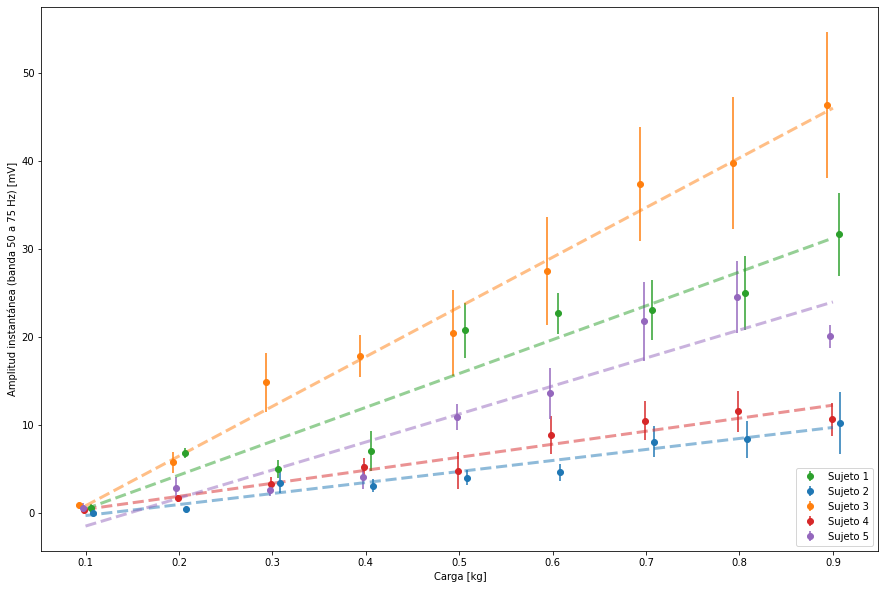

In [24]:
# Select feature to plot and lambda parameter of Box-Cox tranform
feature_name = "Banda ada InstantaneousAmplitude" # feature to plot, use column name in features dataframe
boxcox_lambda =	0.48 # lambda parameter of Box-Cox transform or 1 to disable box-cox transform

# plotting config
feature_name_for_plot = "Amplitud instantánea (banda 50 a 75 Hz) [mV]" # y axes label, change according to feature units
normalize_feature = False # normalize feature with value at max force in MVC test
normalize_force = True # normalize force with max force in MVC test
aggregate = True # group data points in intervals with width equal to 10% of MVC (only enable with normalize_force==True)
linear_regresion = True # plot linear regresion
figsize = (15,10) # matplotlib figure size

# make plot
plt.figure(figsize=figsize)
i = 1
colors = ["tab:green","tab:blue","tab:orange","tab:red","tab:purple","tab:cyan","tab:magenta","tab:brown"]
for grp in force_features.groupby("Subject"):
    if normalize_force:
        x = grp[1]["Force"]/normalization_constants.at["Force",grp[0]]
    else:
        x = grp[1]["Force"]
    if normalize_feature:
        y = grp[1][feature_name]/normalization_constants.at[feature_name,grp[0]]
    else:
        y = grp[1][feature_name]

    if (aggregate and normalize_force):
        x_bins = np.array([0.0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 1.0])
        bin_center = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        indx = np.digitize(x, x_bins)
        y_mean = np.zeros(bin_center.shape[0])
        y_std = np.zeros(bin_center.shape[0])
        for j in range(0,y_mean.shape[0]):
            y_mean[j] = np.median(y.values[np.nonzero(indx == j+1)])
            y_std[j] = np.std(y.values[np.nonzero(indx == j+1)])
        plt.errorbar(bin_center+np.random.normal(loc=0,scale=0.01), y_mean, yerr=y_std, label="Sujeto "+str(i), marker="o", linestyle="none", color=colors[i-1 ])

        if linear_regresion:
            result = stats.linregress(bin_center,y_mean)
            plt.plot(bin_center, result.slope*bin_center+result.intercept,color=colors[i-1],linestyle="--",alpha=0.5,linewidth=3.0)
    else:
        plt.plot(x, stats.boxcox(y, boxcox_lambda), label="Sujeto "+str(i), alpha=0.02, linestyle="none", marker=".",color=colors[i-1])
        if linear_regresion:
            result = stats.linregress(x,stats.boxcox(y, boxcox_lambda))
            plt.plot(x, result.slope*x+result.intercept, color=colors[i-1], linewidth=3.0)

    i += 1

leg = plt.legend(loc='lower right')
if not aggregate:
    for lh in leg.legendHandles:
        lh._legmarker.set_alpha(1)
plt.ylabel(feature_name_for_plot)
plt.xlabel("Carga [kg]")

# Feature in time (endurance tests)

## Feature correlation with time

In [20]:
features = pd.read_csv("endurance_features.csv", sep=";", decimal=".", index_col=0)
normalization_constants = pd.read_excel("results/normalization_constants.xlsx", index_col=0)

In [21]:
features_columns_names = pyMMG.feature_selection.GetFeaturesColumnsNames(features)
    
for feature in features_columns_names:
    for grp in features.groupby(by="Subject"):
        subject = grp[0]
        features.loc[features["Subject"] == subject, feature] /= normalization_constants.at[feature, subject]

for grp in features.groupby(by="Subject"):
        subject = grp[0]
        features.loc[features["Subject"] == subject, "Force"] /= normalization_constants.at["Force", subject]


In [22]:
features_columns_names = pyMMG.feature_selection.GetFeaturesColumnsNames(features)

kendall = {}
pearson = {}
for grp in features.groupby(by="Test ID"):
    subject = grp[1]["Subject"].iloc[0]
    kendall[subject] = grp[1][features_columns_names].corrwith(grp[1]["Time"],method="kendall")
    pearson[subject] = grp[1][features_columns_names].corrwith(grp[1]["Time"],method="pearson")

kendall = pd.DataFrame(kendall).T.describe().T.abs().sort_values(by="mean", ascending=False)
pearson = pd.DataFrame(pearson).T.describe().T.abs().sort_values(by="mean", ascending=False)
pearson

,count,mean,std,min,25%,50%,75%,max
Banda ada MMGScore,5.0,0.732015,0.159743,0.904602,0.826281,0.803483,0.585890,0.539820
Banda add MMGScore,5.0,0.730335,0.179146,0.908608,0.850547,0.800981,0.612927,0.478610
Banda ada MeanOfAmplitude,5.0,0.706257,0.149833,0.884275,0.782286,0.760218,0.583733,0.520771
Banda ada InstantaneousAmplitude,5.0,0.706026,0.149982,0.883893,0.782106,0.760415,0.583954,0.519762
Banda add MeanOfAmplitude,5.0,0.687893,0.230618,0.883891,0.827198,0.798816,0.611502,0.318058
...,...,...,...,...,...,...,...,...
MMG Frequency InterquantileRange50,5.0,0.102647,0.059067,0.181073,0.124065,0.120043,0.053276,0.034778
Banda daa ZeroCrossing,5.0,0.097061,0.301468,0.330652,0.026605,0.117748,0.252736,0.472078
Banda ddd NumberOfTurns,5.0,0.081457,0.242755,0.247936,0.001887,0.027120,0.240256,0.385957
Banda daa NumberOfTurns,5.0,0.072533,0.302693,0.341561,0.074942,0.095539,0.224099,0.459530


## Plot feature variation in time, relative to initial value

Text(0.5, 0, 'Tiempo [s]')

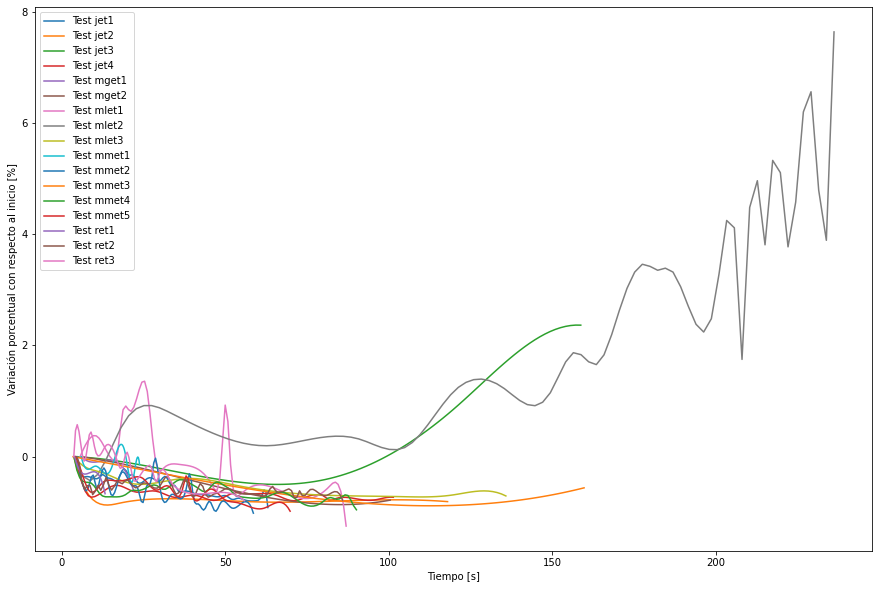

In [46]:
feature = "Banda ada MeanOfAmplitude"
n_points_initial_value = 400*2 # number of points to average and estimate the feature initial value (should be equal to 1s)
figsize = (15,10)

plt.figure(figsize=figsize)
for grp in features.groupby(by="Test ID"):
        x = grp[1]["Time"].values
        y = grp[1][feature].values

        xx = np.linspace(x[0], x[-1], 1000)
        yy = np.interp(xx, x, y)

        spl = interpolate.UnivariateSpline(xx, yy)
        spl.set_smoothing_factor(5.0)

        xs = np.linspace(xx[0], xx[-1], 100)
        plt.plot(xs,(spl(xs)-spl(xs[0]))/spl(xs[0]), label="Test "+str(grp[0]))
        
plt.legend()
plt.ylabel("Variación porcentual con respecto al inicio [%]")
plt.xlabel("Tiempo [s]")

Text(0.5, 0, 'Tiempo [s]')

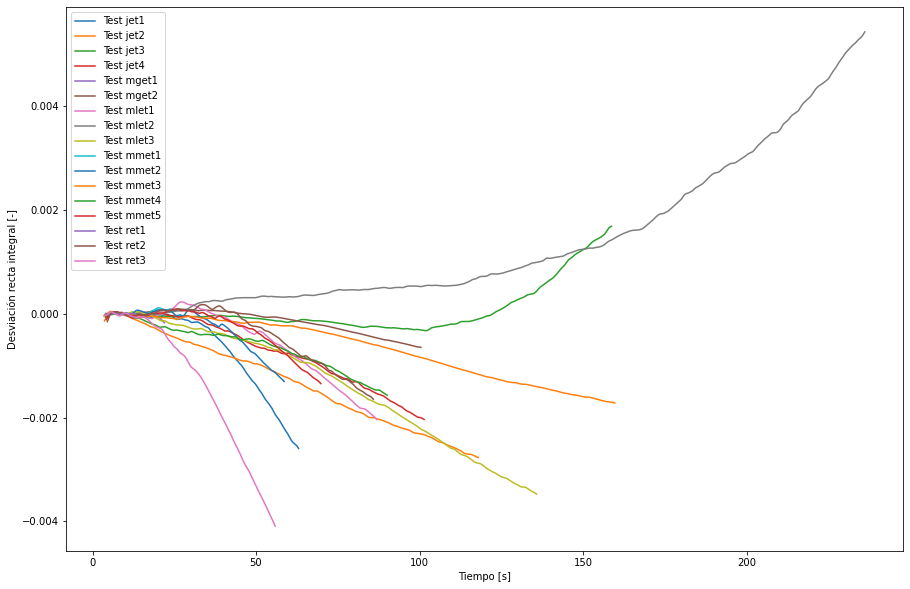

In [58]:
feature = "Banda ada MeanOfAmplitude"
n_points_initial_value = 400*7 # number of points to average and estimate the feature initial value (should be equal to 1s)
figsize = (15,10)

plt.figure(figsize=figsize)
for grp in features.groupby(by="Test ID"):
        x = grp[1]["Time"]
        y = grp[1][feature].values/normalization_constants.at[feature, subject]
        int_y = np.pad(integrate.cumtrapz(y,x=x), (1, 0))
        reg = stats.linregress(x[:n_points_initial_value],int_y[:n_points_initial_value])
        plt.plot(x,int_y-(x*reg.slope+reg.intercept), label="Test "+str(grp[0]))
plt.legend()
plt.ylabel("Desviación recta integral [-]")
plt.xlabel("Tiempo [s]")